# Nonce Distribution Study
Noncesense Research Lab / Monero Archival Project

Nov 2018

This is a "noncesense" study into the empirically observed distribution of nonces in the Monero blockchain between the genesis block and height 1660413.

# Contributors
-  Data: [NeptuneResearch](https://github.com/neptuneresearch)
-  Analysis: [Isthmus](https://github.com/mitchellpkt)


# Before reading this notebook...

... pause for a moment and consider what you would expect to see.

Miners test random nonce values between 0 and 2^32 to find one that produces a hash digest with output value below some threshhold defined by the network difficulty.

For any given block, acceptable nonces are scattered throughout the allowed range, which miners are *presumably* sampling at random. So what patterns (or lack thereof) would you expect in the actual list of nonces reported on the blockchain?

# Analysis

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import mlab
import matplotlib.pyplot as plt
from scipy.stats import norm

## Import data

In [2]:
df = pd.read_csv("./nonce_0_to_1660413.id.csv")
df.describe()

,id,nonce
count,1.660413e+06,1.660413e+06
mean,8.302070e+05,8.929277e+08
std,4.793201e+05,1.334711e+09
min,1.000000e+00,0.000000e+00
25%,4.151040e+05,3.832000e+03
50%,8.302070e+05,1.198900e+05
75%,1.245310e+06,1.717988e+09
max,1.660413e+06,4.294967e+09


## Plot the distribution of nonce values

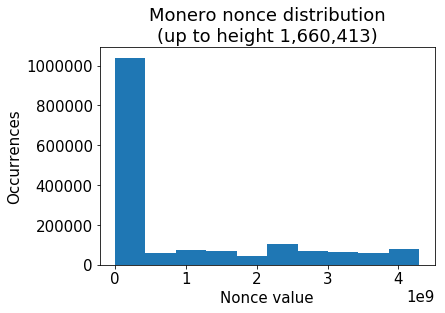

In [3]:
plt.rcParams.update({'font.size': 15})
plt.hist(df.nonce,bins=10);
plt.title('Monero nonce distribution\n(up to height 1,660,413)');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

### ^ That is not uniform!
The above plot shows that the vast majority of nonce values are at the low end of the range.

Let's zoom in on the nonce values on [0, 10^4]

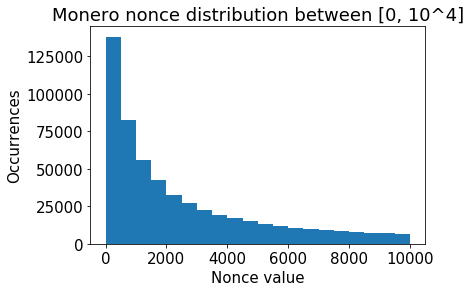

In [4]:
plt.hist(df.nonce[df.nonce<1e4], bins=20);
plt.title('Monero nonce distribution between [0, 10^4]');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

Observed nonce values are heavily concentrated toward the lower end of the allowed range! This is NOT what one would expect. 

Let's take a quick peek at the cumulative distribution function:

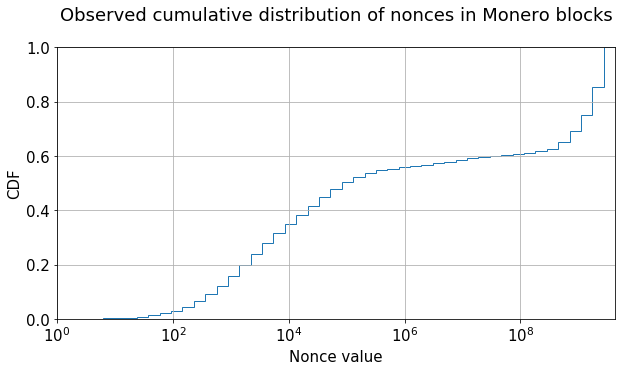

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
bin_edges = bins=np.logspace(np.log10(1),np.log10(4294967296), 50)

# plot the cumulative histogram
n, bins, patches = ax.hist(df.nonce, bins=bin_edges, density=1, histtype='step',
                           cumulative=True)

ax.grid(True)
ax.set_title('Observed cumulative distribution of nonces in Monero blocks\n')
ax.set_xlabel('Nonce value')
ax.set_ylabel('CDF')
ax.set_xscale('log')
ax.set_xlim(1,4294967296)
ax.set_ylim(0,1)
plt.show()

## Observations

Despite a HUGE range of nonce values to choose from (between 1 and ~ 5x10^8) **more than half of the nonces on the blockchain come from the lowest 1% of the range that can be sampled!**

### Two possible explanations: 

Possibility 1: (UNLIKELY) There is a bias in the distribution of acceptable nonce values. This is logically unlikely since the hash function probably has "good" properties and PoW uses the hash of the block contents alongside the nonce.

Possibility 2: Miners are not sampling the space of nonce values randomly.

Possibility two seems more likely, 
